# [IAPR][iapr]: Lab 2 ‒  Object description

**Group ID:** 38

**Author 1 (sciper):** Erfan Etesami (337448)  
**Author 2 (sciper):** Keivan Faghih Niresi (365483)    
**Author 3 (sciper):** Mohammad Amine Ben Ahmed (300371)   

**Release date:** 24.03.2023  
**Due date:** 07.04.2023 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library. In the `lab-02-data` folder, you will find 28x28 grey-scale pictures of handwritten "0", "1", "2" and "3".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

### 0.1.Data visualization

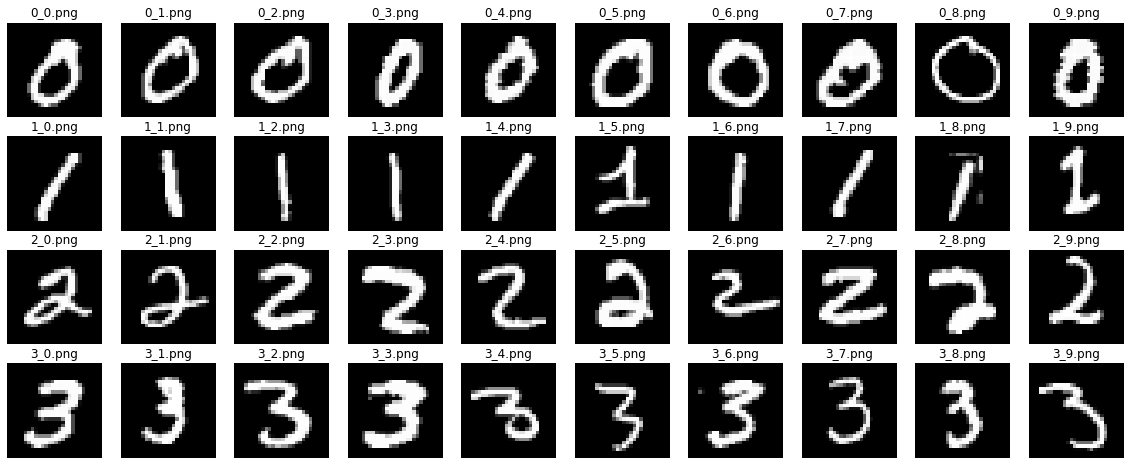

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
# Load digits data

# Zero images arrays
zeros_im, zeros_names = load(data_part1, digit='0')
# Ones images arrays
ones_im, ones_names = load(data_part1, digit='1')
# Twos images arrays
twos_im, twos_names = load(data_part2, digit='2')
# Threes images arrays
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(4, len(zeros_im), figsize=(20, 8))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[2], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[3], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

In [3]:
import numpy as np

from skimage.exposure import histogram
from skimage.measure import find_contours, inertia_tensor_eigvals
from skimage.transform import rotate, rescale, warp, AffineTransform

import cv2

from scipy.interpolate import interp1d
from scipy.fft import fft, ifft, fftfreq

from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler

import itertools

import matplotlib.pyplot as plt
%matplotlib inline

---
## Part 1 - contour based descriptors (18 pts)

In this part you will use images of "0"s and "1"s.

**Objectives overview**: Fourier Descriptors


**1)** *Preprocess*: Select ONLY "0" and "1" images and apply suitable preprocessing. Show a plot with the preprocessed data and give arguments on the chosen techniques. (**2 pts**)


**2)** *Get descriptors*: Find the contours and get the Fourier descriptors in complex definition. *Note*: The contours arrays should contain a finite number (N-> self-chosen) of equi-distant points for each image (hint: interpolation). In the case of the "0" contours, just keep the outermost contour. Discuss the necessity of this format. (**4 pts**)
    
    
**3)** *Study effect of descriptors* : Show the contour-reconstruction of the digits using different amount of descriptors (both for ONE "0" image and ONE "1" image)
- Make 5 plots, reconstructing the digits' countours using different amounts of descriptors. (e.g. reconstruct the contour using the only the 1st fourier descriptor, reconstruct using the first two fourier descriptors,  using the first three ...)  
- **Hint**: check scipy fft, ifft, and fftfreq functions (see [link](https://docs.scipy.org/doc/scipy/tutorial/fft.html)) and pay attention on the ordering, observing which coefficients correspond to positive/negative frequencies of components and how you choose your low frequency subsets . 
- **Extra hint** To reconstruct the contour, copy the original vector of the fourier descriptors, keep the positive an negative frequencies you will use, and set to 0 the rest. (e.g. If you want to reconstruc the image with the first _three fourier descriptors_, keep the first _three positive frecuencies_ and their respective _three negative frequencies_ (see positive and negative bin freque
    frequencies [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fftfreq.html#scipy.fft.fftfreq) ). 
- Discuss about your findings. (**4 pts**)
    
        
**4)** *Clustering*: For each image containing a "0" or a "1", using the fourier descriptors, extract a 2-dimensional feature vector (using the THE POSITIVE bin frequencies from fftfreq, see [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fftfreq.html#scipy.fft.fftfreq) ) and plot all of them on a 2D graph. Did you obtain a plot where the vectors of the "0"'s nicely cluster in one part of the plane and those of the "1"'s in the other? If yes, explain why. (**2 pts**)
    
    
**5)** *Show translation, rotation and scale invariance*
- Firstly, discuss which descriptors, or which part of the descriptors are affected by each transformation. For each transformation define (write in words) an operation which will be applied to the descriptor arrays, such that they will be invariant to (not affected by) the specific transformation anymore. After finding the necessary operations, define a function that will make the Fourier descriptors invariant to all the transformations, altogether.(**3 pts**) 
- Secondly, show that if you are using descriptors invariant to transformations, you still obtain 2 nicely defined clusters for the 2 categories of numbers, under transformations applied. (You need to define custom functions for each transformation, apply them on images, and compare the obtained invariant descriptors). Discuss your findings. (**3 pts**)

### 1. Fourier Descriptors

### 1.1. Preprocess and visualization (2 pts)

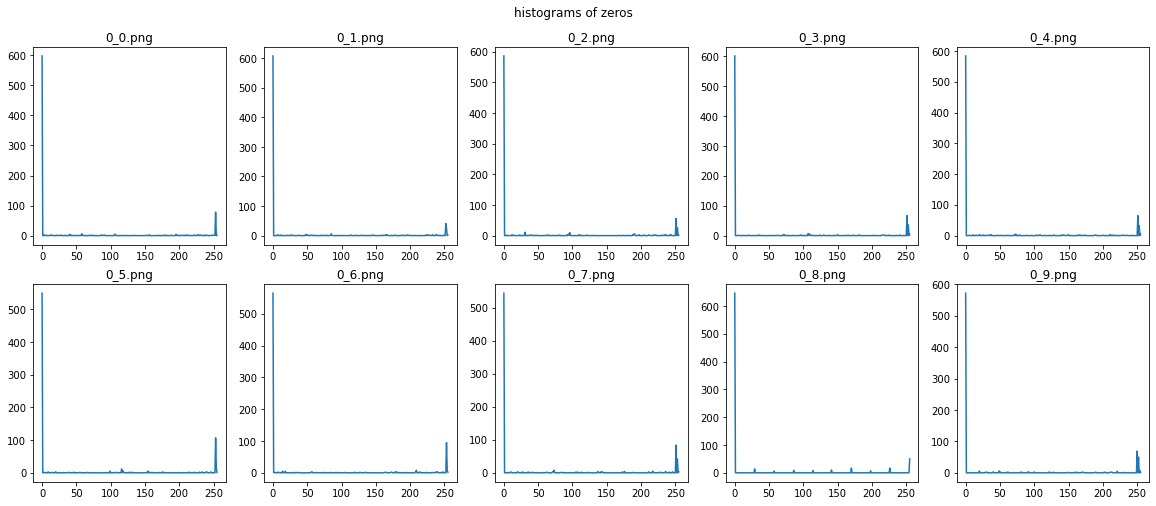

In [4]:
# visualizing the histograms of zeros
fig, axes = plt.subplots(2, int(np.ceil(len(zeros_im)/2)), figsize=(20, 8))
for i in range(0, len(zeros_im), 1):
    ax = axes.ravel()[i]
    hist_vals, hist_centers = histogram(zeros_im[i], nbins=256)
    ax.plot(hist_centers, hist_vals)
    ax.set_title(zeros_names[i])
fig.suptitle('histograms of zeros', y=0.95)
plt.show()

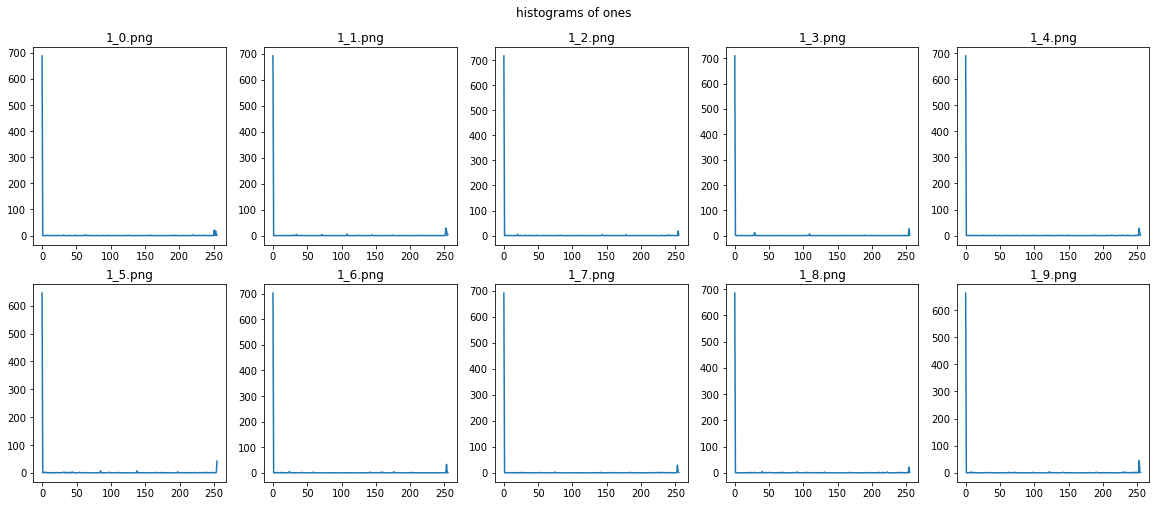

In [5]:
# visualizing the histograms of ones
fig, axes = plt.subplots(2, int(np.ceil(len(ones_im)/2)), figsize=(20, 8))
for i in range(0, len(ones_im), 1):
    ax = axes.ravel()[i]
    hist_vals, hist_centers = histogram(ones_im[i], nbins=256)
    ax.plot(hist_centers, hist_vals)
    ax.set_title(ones_names[i])
fig.suptitle('histograms of ones', y=0.95)
plt.show()

In [6]:
def preprocess(img, threshold):
    """
    preprocessing the input image by thresholding
    """
    
    img = img.copy()
    img[img < threshold] = 0
    img[img >= threshold] = 255
    return img

In [7]:
# thresholding zeros and ones based on the histograms
threshold = 100
zeros = zeros_im.copy()
for i in range(0, len(zeros), 1):
    zeros[i] = preprocess(zeros[i], threshold=threshold)
ones = ones_im.copy()
for i in range(0, len(ones), 1):
    ones[i] = preprocess(ones[i], threshold=threshold)

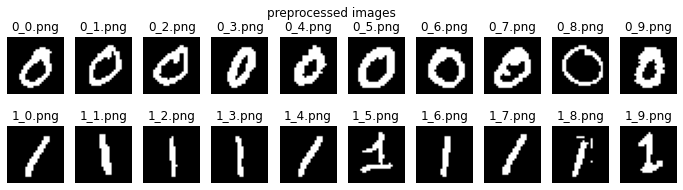

In [8]:
# plotting the thresholded images
fig, axes = plt.subplots(2, len(zeros), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
fig.suptitle("preprocessed images")
plt.show()

#### Discussion

As the preprocessing step, we have created binary images by thresholding them based on the histogram visualizations. This step removes little blurred artifacts from the images, and hereby, assist the contour detection process.

### 1.2. Get descriptors (4 pts)

In [9]:
# Function that takes as input an image and returns a set of descriptors. 
# You may use other custom helper functions to break the code into useful chuncks.

def find_outermost_contour(img):
    """
    img is assumed to have undergone the required preprocessing steps
    """

    contours = find_contours(img)
    # choosing the outermost contour, i.e., the longest one
    contours = sorted(contours, key=len, reverse=True)
    contour_outermost = contours[0]
    return contour_outermost


def interpolate_contour(contour, contour_length_desired):
    """
    interpolating the contour to a fixed length
    """
    kind = 'cubic'  # cubic spline interpolation for higher accuracy
    idx_interpolated = np.linspace(0, len(contour), num=contour_length_desired, endpoint=False)
    contour_interpolated = np.full((contour_length_desired, 2), np.nan)
    f_x = interp1d(range(contour.shape[0]), contour[:, 1], kind=kind, fill_value="extrapolate")   
    contour_interpolated[:, 1] = f_x(idx_interpolated)
    f_y = interp1d(range(contour.shape[0]), contour[:, 0], kind=kind, fill_value="extrapolate")    
    contour_interpolated[:, 0] = f_y(idx_interpolated)
    return contour_interpolated


def get_descriptors(img, contour_length_desired):
    """ 
    img is assumed to have undergone the required preprocessing steps
    contour_length_desired is the desired length of the contour after interpolation. Note that its value 
    is based on the length of the contour found in the preprocessed image.
    """

    # finding the outermost contour of the image
    contour_outermost = find_outermost_contour(img)
    
    # interpolating the contour so that it has a fixed length with the same spacing between points
    contour_interpolated = interpolate_contour(contour_outermost, contour_length_desired)

    # generating a complex-valued signal from the contour
    u = np.full(contour_interpolated.shape[0], np.nan, dtype=np.complex_)
    for i in range(len(u)):
        u[i] = contour_interpolated[i, 1] + 1j*contour_interpolated[i, 0]

    # computing the fourier descriptor (DFT)
    descriptors = fft(u)
    
    return descriptors

# Check first 10 descriptors of a test image (just to check that your pipeline works well)
print(get_descriptors(zeros[0], 80)[:10])

[ 1.12637114e+03+1.18986550e+03j -1.30907497e+02+6.52410657e+02j
 -1.43284330e+01+5.05966123e+00j  2.71621128e+01+3.48609648e+01j
  1.00081542e+01-1.63483324e+01j  8.42168355e-01+9.82459633e+00j
 -5.32205899e+00-4.80354795e+00j  1.14593269e+00-4.48343106e+00j
  1.85713206e+00+3.43136876e+00j  1.91548609e+00+3.62871378e-01j]


#### Discussion

After finding all the contours of the preprocessed image, the longest one corresponding to the outermost one has been selected. This procedure helps filtering out small artifacts like the short lines around the "1" in image 1_8. 

Moreover, to be able to compare the fourier descriptors of various contours, they all need to be of the same length. The reason is one has to make sure the first Fourier descriptors found with **fft** for diffrent signals match one another. Therefore, a linear interpolation has been applied to the contour to fill the missing points while having the fixed desired ocntour length. 

Afterward, the contour has been transformed to a complex signal ($u_k = x_k + j*y_k$). This complex signal is then fed to **fft** to compute complex-valued Fourier descriptors. 

### 1.3. Study effect of descriptors (6 pts)

In [10]:
# Define increasing set sizes of the descriptors. You can also change these numbers.
descr_set_sizes = [1, 2, 5, 10, 20, 80]

# Define images for which you will show the recovery. You can also change the indexes.
zero = zeros_im[0]
one = ones_im[0]

In [11]:
def reconstruct_descriptors(descriptors, n):
    # truncating the descriptors
    N = len(descriptors)
    descriptors[n+1:N//2] = 0
    descriptors[-N//2:-n] = 0
    # reconstructing the signal
    real = ifft(descriptors).real
    imag = ifft(descriptors).imag
    reconstruction = np.column_stack((real, imag))
    return descriptors, reconstruction

In [12]:
# processing the images
zero_processed = preprocess(zero, threshold=100)
one_processed = preprocess(one, threshold=100)

# finding the original contours of the images
zero_contour_org = find_contours(zero_processed)[0]
one_contour_org = find_contours(one_processed)[0]

# initializing the arrays for the reconstructed images
zero_reconstructed_arr = [None]*len(descr_set_sizes)
one_reconstructed_arr = [None]*len(descr_set_sizes)

# computing the Fourier descriptors for the images
contour_length_desired = 80
zero_descriptors = get_descriptors(zero_processed, contour_length_desired)  
one_descriptors = get_descriptors(one_processed, contour_length_desired)

# reconstructing the images
for i in range(len(descr_set_sizes)):
    n = descr_set_sizes[i]
    zero_reconstructed_arr[i] = reconstruct_descriptors(zero_descriptors.copy(), n)[1]
    one_reconstructed_arr[i] = reconstruct_descriptors(one_descriptors.copy(), n)[1]


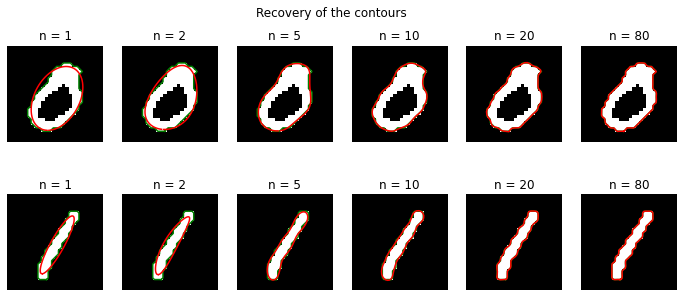

In [13]:
# On each of the 5 plots you will show the recovery for a "0" and a "1" (used the same axis for both a "0" and a "1").
fig, axes = plt.subplots(2, 6, figsize=(12, 5))

# Plot recovery for a zero image
for i in range(0,  6):
    axes[0, i].imshow(zero_processed, cmap='gray')
    axes[0, i].plot(zero_contour_org[:, 1], zero_contour_org[:, 0], 'g')    # green contour is the original one
    axes[0, i].plot(zero_reconstructed_arr[i][:, 0], zero_reconstructed_arr[i][:, 1], 'r')  # red contour is the reconstructed one
    axes[0, i].set_title('n = ' + str(descr_set_sizes[i]))
    axes[0, i].axis('off')

# Plot recovery for a one image
for i in range(0,  6):
    axes[1, i].imshow(one_processed, cmap='gray')
    axes[1, i].plot(one_contour_org[:, 1], one_contour_org[:, 0], 'g')  # green contour is the original one
    axes[1, i].plot(one_reconstructed_arr[i][:, 0], one_reconstructed_arr[i][:, 1], 'r')    # red contour is the reconstructed one
    axes[1, i].set_title('n = ' + str(descr_set_sizes[i]))
    axes[1, i].axis('off')

fig.suptitle('Recovery of the contours', y=0.95)
plt.show()

#### Discussion

Note that the discriptor with index 0 represents the mean value of the contour (center of the shape). More specifically, the 0-th dsecriptor is associated with the position of the shape (not the actual shape itself).

Considering **x** as the input to inverse DFT and **n** as its length, one should note that
- x[0] should contain the zero frequency term,
- x[1:n//2] should contain the positive-frequency terms,
- x[n//2+1:] should contain the negative-frequency terms, in increasing order starting from the most negative frequency.
- if n is even, then x[n//2] represents the sum of the values at the positive and negative Nyquist frequencies, as the two are aliased together.

To reconstruct the contour, the desired number of positive an negative frequencies of the Fourier descriptors are kept while the rest are set to 0.

As it can be seen from the above figure (green contour is the original one and red contour is the reconstructed one), the first few descriptors already give a good estimate of the overall shape of the contour. Moreover, it is clear that as the number of selected Fourier descriptors increases, the reconstructed contour (red) gets closer and closer to the original one (green) because the truncation error gets smaller and smaller. More specifically, the edges and sharp changes gets estimated better. Ultimately (n=80), the reconstruction matches the original contour up to numerical accuracy and small error due to linear interpolation.

### 1.4 Clustering (2 pts)

In [14]:
idx_desired = [1, 2]
zeros_features = np.zeros((len(zeros), len(idx_desired)))
ones_features = np.zeros((len(ones), len(idx_desired)))
contour_length_desired = 80
for im, i in zip(zeros, range(len(zeros_features))):
    descriptors = get_descriptors(im, contour_length_desired)
    zeros_features[i, :] = np.abs(descriptors[idx_desired])
for im, i in zip(ones, range(len(ones_features))):
    descriptors = get_descriptors(im, contour_length_desired)
    ones_features[i, :] = np.abs(descriptors[idx_desired])

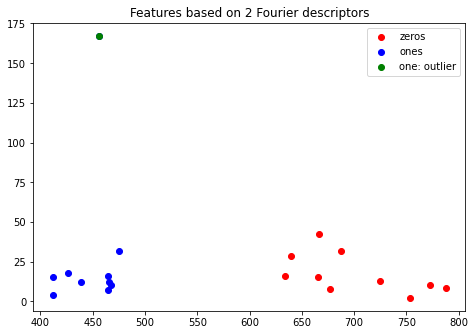

In [15]:
# First feature for all "0"s
zeros_f1 = zeros_features[:, 0]
# Second feature for all "0"s
zeros_f2 = zeros_features[:, 1]
# Fist feature for all "1"s
ones_f1 = ones_features[:, 0]
# Second feature for all "1"s
ones_f2 = ones_features[:, 1]

# Plot features for all images
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(zeros_f1, zeros_f2, color='r', label='zeros')
ax.scatter(ones_f1, ones_f2, color='b', label='ones')
ax.scatter(ones_f1[5], ones_f2[5], color='g', label='one: outlier')
ax.legend(loc='best')
plt.title("Features based on 2 Fourier descriptors")
plt.show()

#### Discussion


As mentioned earlier, descriptor with index 0 is only representive of the center of the shape (not the shape itself). Therefore, it has not been considered for the clustering (to be invariant to translation). Subsequently, to extract the intended 2-dimentional feature vectors, the Fourier descriptors with index=[1,2] are employed.

Note that the absolute value (magnitude) of the Fourier descriptors at positive bins are utilized since the descriptors themselves are complex-valued.

Evidently, two clusters are clearly seperable (zeros are on bottom right and ones are on bottom left). Note that a linear boundary can now easily seprate zeros from ones (shown below). This has been expected since the first descriptors carry the majority of information abour the overall shape of the object and '0' and '1' have quite different shapes ('0' is round and curvy, whereas '1' is almost piece-wise linear). It is also noteworthy the image 1_5 is an outlier because of its unusual curvy shape. gegardless, it can still be correclty clustered. Moreover, ignoring the image 1_5, the ones have a smaller intraclass variance compared to the zeros. The reason is that most of the ones are just simple lines tilted with respect to each other. But, from the lecture slides, we know that rotation affects the phase not magintude (used for clustering).

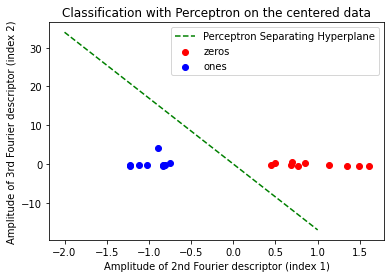

In [16]:
def classify(class1_features, class2_features, class1_label, class2_label, x_label, y_label):
    X = np.concatenate([np.array(class1_features), np.array(class2_features)])
    sc = StandardScaler()
    sc.fit(X)
    X = sc.transform(X)
    y = np.array([0 for _ in range(class1_features.shape[0])] + [1 for _ in range(class2_features.shape[0])])
    clf = Perceptron(random_state=17, fit_intercept=True)
    model = clf.fit(X, y)
    
    w, w0 = np.squeeze(clf.coef_), clf.intercept_[0]
    w1, w2 = w[0], w[1]
    x = np.arange(-2, 2)
    line = (-w1 / w2) * x - (w0 / w2)

    plt.scatter(X[y==0, 0], X[y==0, 1], label=class1_label, color='r', marker='o')
    plt.scatter(X[y==1, 0], X[y==1, 1], label=class2_label, color='b', marker='o')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(x, line, color='g', linestyle='--', label='Perceptron Separating Hyperplane')
    plt.legend()
    plt.title('Classification with Perceptron on the centered data')
    plt.show()

classify(zeros_features, ones_features, 'zeros', 'ones',
         'Amplitude of 2nd Fourier descriptor (index 1)', 'Amplitude of 3rd Fourier descriptor (index 2)')   

### 1.5 Transformation invariance (6 pts)

#### Preliminary discussion

Based on the lecture slides, we expect to see that rotation does not affect the magnitude (amplitude) of Fourier descriptors (since it only affects the phase). Moreover, it is expected that translation only alters the first Fourier descriptor (index 0); therefore, other descriptors should maintain their values. Furthermore, scaling is supposed to not disturb the ratio between descriptors.

#### Implementation

In [17]:
# Implement a function that takes as input an image and outputs 
# a set of features invariant to scale, rotation and translation, according to function boolean parameters.
# You may use your functions defined in section 1.B.

def get_invariant_features(img, inv_to_rotation=False, inv_to_translation=False, inv_to_scale=False):
    contour_length_desired = 80
    descriptors = get_descriptors(img, contour_length_desired)  
    features = np.zeros_like(descriptors)
    if inv_to_rotation: # it does not affect the ampltude
        features = np.abs(descriptors)
    elif inv_to_translation:    # it only affects the first descriptor
        features = np.abs(descriptors[1:])
    elif inv_to_scale:  # it does not affect the ratio between the descriptors
        features = np.abs(descriptors / descriptors[0])
    return features

In [18]:
# Define custom rotation function. You may add other parameters to the function.
def random_rotate(img):
    order = 3   # cubic spline interpolation to get higher accuracy
    mode = 'constant'   # fill with zeros at boundaries
    angle = np.random.rand()*360
    return rotate(img, angle, order=order, mode=mode, preserve_range=True), angle


# Define custom rotation function. You may add other parameters to the function.
def random_translate(img):
    order = 3   # cubic spline interpolation to get higher accuracy
    mode = 'constant'   # fill with zeros at boundaries
    translation = np.random.rand(2)*10 - 5
    trans_mat = AffineTransform(translation=translation)
    # trans_mat_inv = np.linalg.inv(trans_mat)
    return warp(img, trans_mat, order=order, mode=mode, preserve_range=True), translation


# Define custom rotation function. You may add other parameters to the function.
def random_scale(img):
    order = 3   # cubic spline interpolation to get higher accuracy
    mode = 'constant'   # fill with zeros at boundaries
    scale = np.random.rand()*2 + 0.5
    return rescale(img, scale, order=order, mode=mode, preserve_range=True), scale

# combining all the above transformations sequentially (1st: rotation, 2nd: translation, 3rd: scaling)
def random_all(img):
    img, angle = random_rotate(img)
    img, translation = random_translate(img)
    img, scale = random_scale(img)
    return img, angle, translation, scale

In [19]:
# We will define 4 sets of new images below

# Apply only rotation for each "0" and "1" and store results below
temp = [random_rotate(zeros_im[i]) for i in range(len(zeros_im))]
rotated_images_zeros = [(preprocess(item[0], 100).astype(int), item[1]) for item in temp]
temp = [random_rotate(ones_im[i]) for i in range(len(ones_im))]
rotated_images_ones = [(preprocess(item[0], 100).astype(int), item[1]) for item in temp]

# Apply only translation for each "0" and "1" and store results below
temp = [random_translate(zeros_im[i]) for i in range(len(zeros_im))]
translated_images_zeros = [(preprocess(item[0], 100).astype(int), item[1]) for item in temp]
temp = [random_translate(ones_im[i]) for i in range(len(ones_im))]
translated_images_ones = [(preprocess(item[0], 100).astype(int), item[1]) for item in temp]

# Apply only scaling for each "0" and "1" and store results below
temp = [random_scale(zeros_im[i]) for i in range(len(zeros_im))]
scaled_images_zeros = [(preprocess(item[0], 100).astype(int), item[1]) for item in temp]
temp = [random_scale(ones_im[i]) for i in range(len(ones_im))]
scaled_images_ones = [(preprocess(item[0], 100).astype(int), item[1]) for item in temp]

# Apply all 3 transformations sequentially, in your custom order, for each "0" and "1" and store results below
temp = [random_all(zeros_im[i])for i in range(len(zeros_im))]
transformed_images_zeros = [(preprocess(item[0], 100).astype(int), item[1]) for item in temp]
temp = [random_all(ones_im[i]) for i in range(len(ones_im))]
transformed_images_ones = [(preprocess(item[0], 100).astype(int), item[1]) for item in temp]

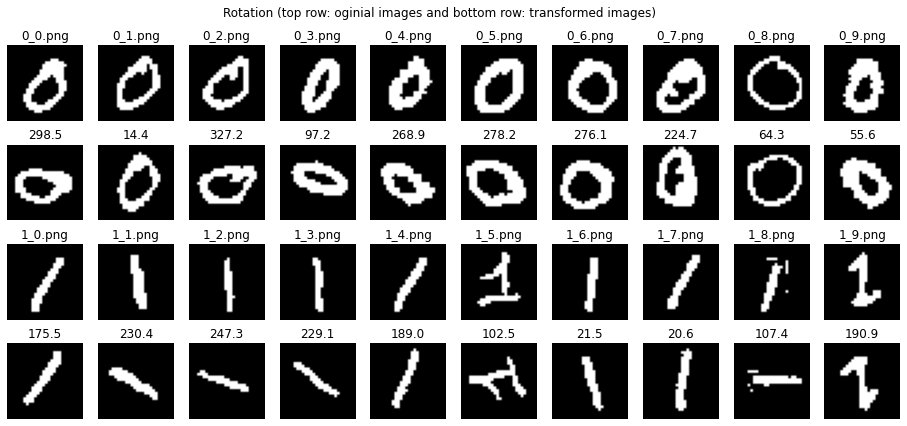

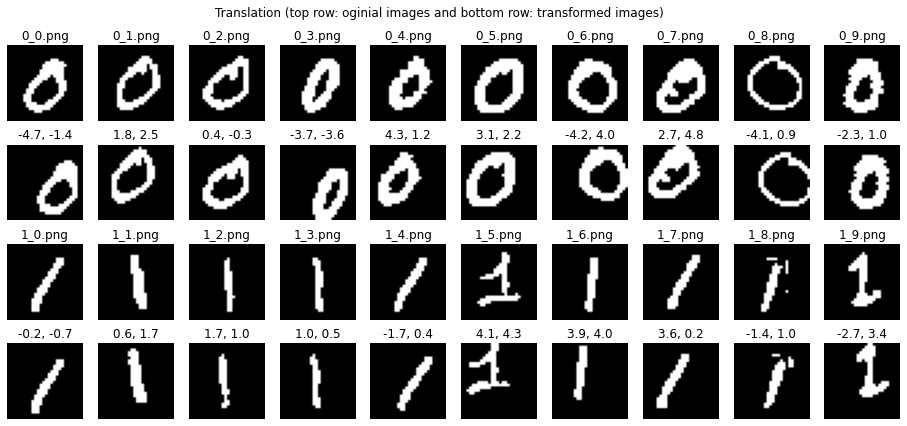

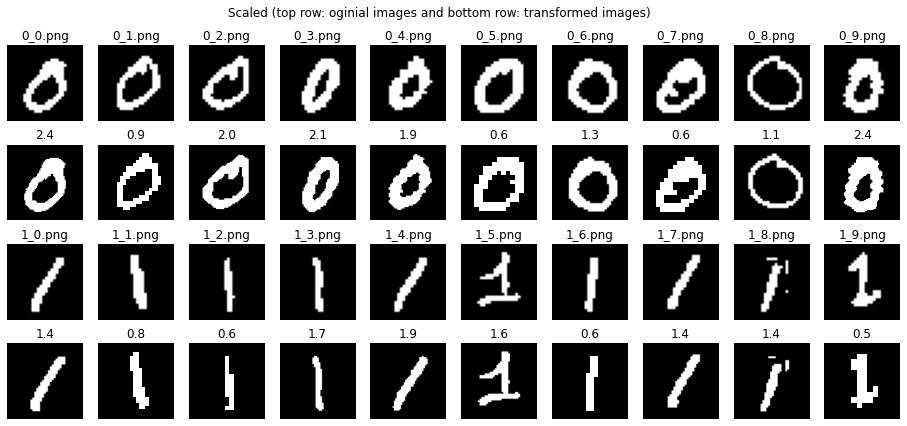

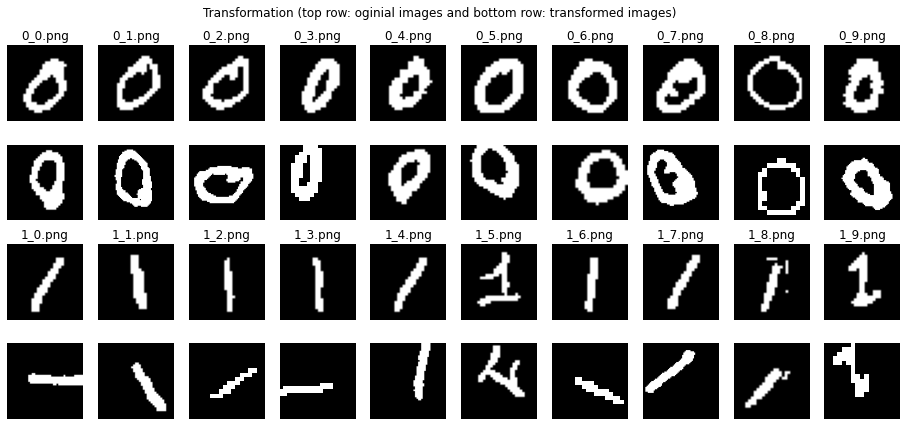

In [20]:
# Plot images for rotation
fig, axes = plt.subplots(4, len(zeros), figsize=(16, 7))
for ax, im, nm in zip(axes[0], zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, item in zip(axes[1], rotated_images_zeros):
    ax.imshow(item[0], cmap='gray')
    ax.axis('off')
    ax.set_title('{:.1f}'.format(item[1]))
for ax, im, nm in zip(axes[2], ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, item in zip(axes[3], rotated_images_ones):
    ax.imshow(item[0], cmap='gray')
    ax.axis('off')
    ax.set_title('{:.1f}'.format(item[1]))
fig.suptitle('Rotation (top row: oginial images and bottom row: transformed images)', y=0.95)
plt.show()
# Plot images for translation
fig, axes = plt.subplots(4, len(zeros), figsize=(16, 7))
for ax, im, nm in zip(axes[0], zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, item in zip(axes[1], translated_images_zeros):
    ax.imshow(item[0], cmap='gray')
    ax.axis('off')
    ax.set_title('{:.1f}, {:.1f}'.format(item[1][0], item[1][1]))
for ax, im, nm in zip(axes[2], ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, item in zip(axes[3], translated_images_ones):
    ax.imshow(item[0], cmap='gray')
    ax.axis('off')
    ax.set_title('{:.1f}, {:.1f}'.format(item[1][0], item[1][1]))
fig.suptitle('Translation (top row: oginial images and bottom row: transformed images)', y=0.95)
plt.show()
# Plot images for scaling
fig, axes = plt.subplots(4, len(zeros), figsize=(16, 7))
for ax, im, nm in zip(axes[0], zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, item in zip(axes[1], scaled_images_zeros):
    ax.imshow(item[0], cmap='gray')
    ax.axis('off')
    ax.set_title('{:.1f}'.format(item[1]))
for ax, im, nm in zip(axes[2], ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, item in zip(axes[3], scaled_images_ones):
    ax.imshow(item[0], cmap='gray')
    ax.axis('off')
    ax.set_title('{:.1f}'.format(item[1]))
fig.suptitle('Scaled (top row: oginial images and bottom row: transformed images)', y=0.95)
plt.show()
# Plot images for custom transformation
fig, axes = plt.subplots(4, len(zeros), figsize=(16, 7))
for ax, im, nm in zip(axes[0], zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, item in zip(axes[1], transformed_images_zeros):
    ax.imshow(item[0], cmap='gray')
    ax.axis('off')
for ax, im, nm in zip(axes[2], ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, item in zip(axes[3], transformed_images_ones):
    ax.imshow(item[0], cmap='gray')
    ax.axis('off')
fig.suptitle('Transformation (top row: oginial images and bottom row: transformed images)', y=0.95)
plt.show()

In [21]:
def generate_zeros_ones_features(zeros, ones, inv_to_roation=False, inv_to_translation=False, inv_to_scaling=False, is_custom=False):
    if inv_to_roation or inv_to_scaling or is_custom:
        # second and third descriptors are suitable here 
        idx_desired = [1, 2]
    elif inv_to_translation:
        # second and third descriptors are suitable here
        # (the first discriptor will be removed by get_invariant_features function)
        idx_desired = [0, 1]
    zeros_features = np.zeros((len(zeros), len(idx_desired)))
    ones_features = np.zeros((len(ones), len(idx_desired)))
    if is_custom:
        for im, i in zip(zeros, range(len(zeros_features))):
            descriptors = get_descriptors(im, 80)
            descriptors = descriptors / descriptors[0]
            zeros_features[i, :] = np.abs(descriptors[idx_desired])
        for im, i in zip(ones, range(len(ones_features))):
            descriptors = get_descriptors(im, 80)
            descriptors = descriptors / descriptors[0]
            ones_features[i, :] = np.abs(descriptors[idx_desired])
    else:
        for im, i in zip(zeros, range(len(zeros_features))):
            features = get_invariant_features(im, inv_to_roation, inv_to_translation, inv_to_scaling)
            zeros_features[i, :] = features[idx_desired]
        for im, i in zip(ones, range(len(ones_features))):
            features = get_invariant_features(im, inv_to_roation, inv_to_translation, inv_to_scaling)
            ones_features[i, :] = features[idx_desired]
    return zeros_features, ones_features

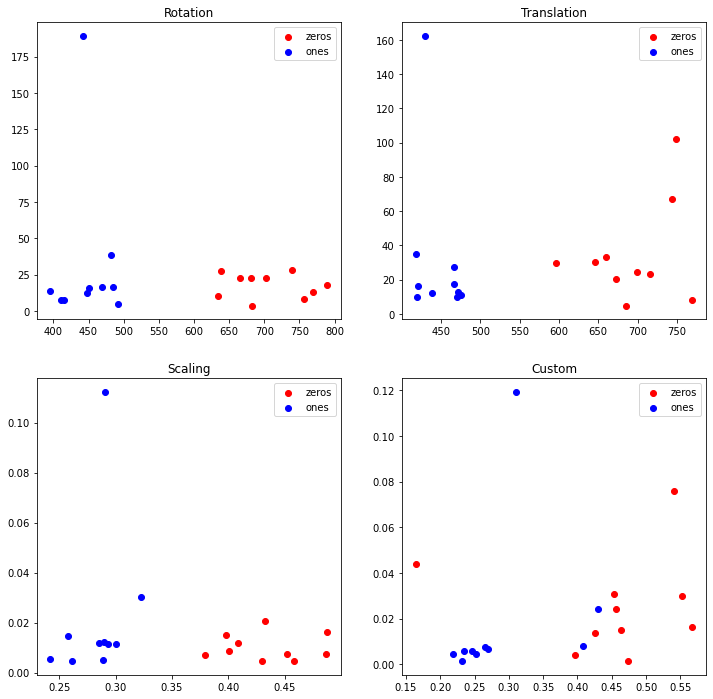

In [22]:
# For each of the 4 sets of "0"s and "1"s above, you should find the invaiant features
# and make a plot (similar to section 1.4) - 4 plots in total!
# Use a proper labeling/legend for the plots!

temp_zeros = [item[0] for item in rotated_images_zeros]
temp_ones = [item[0] for item in rotated_images_ones]
rotation_zeros_features, rotation_ones_features = generate_zeros_ones_features(temp_zeros, temp_ones, inv_to_roation=True)
temp_zeros = [item[0] for item in translated_images_zeros]
temp_ones = [item[0] for item in translated_images_ones]
translation_zeros_features, translation_ones_features = generate_zeros_ones_features(temp_zeros, temp_ones, inv_to_translation=True)
temp_zeros = [item[0] for item in scaled_images_zeros]
temp_ones = [item[0] for item in scaled_images_ones]
scaling_zeros_features, scaling_ones_features = generate_zeros_ones_features(temp_zeros, temp_ones, inv_to_scaling=True)
temp_zeros = [item[0] for item in transformed_images_zeros]
temp_ones = [item[0] for item in transformed_images_ones]
custom_zeros_features, custom_ones_features = generate_zeros_ones_features(temp_zeros, temp_ones, is_custom=True)

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes[0, 0].scatter(rotation_zeros_features[:, 0], rotation_zeros_features[:, 1], color='r', label='zeros')
axes[0, 0].scatter(rotation_ones_features[:, 0], rotation_ones_features[:, 1], color='b', label='ones')
axes[0, 0].legend(loc='best')
axes[0, 0].set_title("Rotation")
axes[0, 1].scatter(translation_zeros_features[:, 0], translation_zeros_features[:, 1], color='r', label='zeros')
axes[0, 1].scatter(translation_ones_features[:, 0], translation_ones_features[:, 1], color='b', label='ones')
axes[0, 1].legend(loc='best')
axes[0, 1].set_title("Translation")
axes[1, 0].scatter(scaling_zeros_features[:, 0], scaling_zeros_features[:, 1], color='r', label='zeros')
axes[1, 0].scatter(scaling_ones_features[:, 0], scaling_ones_features[:, 1], color='b', label='ones')
axes[1, 0].legend(loc='best')
axes[1, 0].set_title("Scaling")
axes[1, 1].scatter(custom_zeros_features[:, 0], custom_zeros_features[:, 1], color='r', label='zeros')
axes[1, 1].scatter(custom_ones_features[:, 0], custom_ones_features[:, 1], color='b', label='ones')
axes[1, 1].legend(loc='best')
axes[1, 1].set_title("Custom")
plt.show()

#### Discussion

**Rotation**: 

Clearly, ones and zeros are separable (a linear classfication like before will easily do the job). The selected features here are just the amplitude of the second (index=1) and third (index=2) Fourier descriptors suggesting that the magnitude is invariant to ratation.

The plot itself looks quite similar to the original (unrotated) version. Note that the exact position of each datapoint is not exactly the same as before. This is partly due to the interpolation in rotation (although the accurate cubic spline is chosen here, the positions are more different using linear interpolation). Also recall that the rotated images are the roatted version of original (not thresholed) images that are then binarized. Obviously, the detected contours in this case are different from those found by thresholding the original images direclty. Moreover, the interpolation that has been done to obtain the contours with fixed length imposes some additional errors.

**Translation**:

Two clusters are nicely seperable as expected. This shows that the amplitude of the second (index=1) and third Fourier (index=2) descriptors are invariant to translation. Again, the exact position is different from the original clusters due to reasons mentioned for **roation**.

**Scaling**:

Evidenlty, ones and zeros are mapped into seperable clusters. The features here are the ratio of the magnitude of the second (index=1) and third (index=2) Fourier descriptors over the amplitude of the first (index=0) descriptor. As expected, this ratio is invariant to translation.

**Custom**:

The custom transformation consists of a sequence of one random rotation, one random translation, and one random scaling. Overall, one can expect that features based on the ratio of the second (index=1) and third (index=2) Fourier decriptors with respect to the first (index=0) should be invariant to the combination of transformation, rotation, and scaling. This is because, roation does not change the amplitude, tranfromation only affects the first descriptor, and scaling will be cancel out by computing the ratio. Based on the figure, two clusters of zeros and ones are almost separable (some overlap can be observed). The reason for this can be attributed to the sources of errors (interpolation in two different parts and the seuqence of binarization) pointed out for the case of **rotation**.

Note that because of the randomness, these result might slighlty change from run to run.


## PART 2 - region based descriptors (10 pts)

In this part, you will use the "2"s and "3"s images.

**Objectives overview**:

**1)** *Cluster on compacity*: Based on custom definitions of perimeter and area for each image of "2" and "3" (preprocessed - by you), make a 2D plot with 2-dimensional feature vectors, similar to section 1.4. After that, define the compacity feature for each "2"s and "3"s image. Are you still able to obtain a 1D plot with values clustered in 2 well-defined regions? Discuss your findings. (**6 pts**).

**2)** *Additional method*: Choose one more region-based method (from the course or your own sources - internet allowed) and redo the 1D plot in section 2.1 (or 2D plot, depending on your choosing). Explain your method and your findings. (**4 pts**)

### 2.3. Cluster on compacity (6 pts)

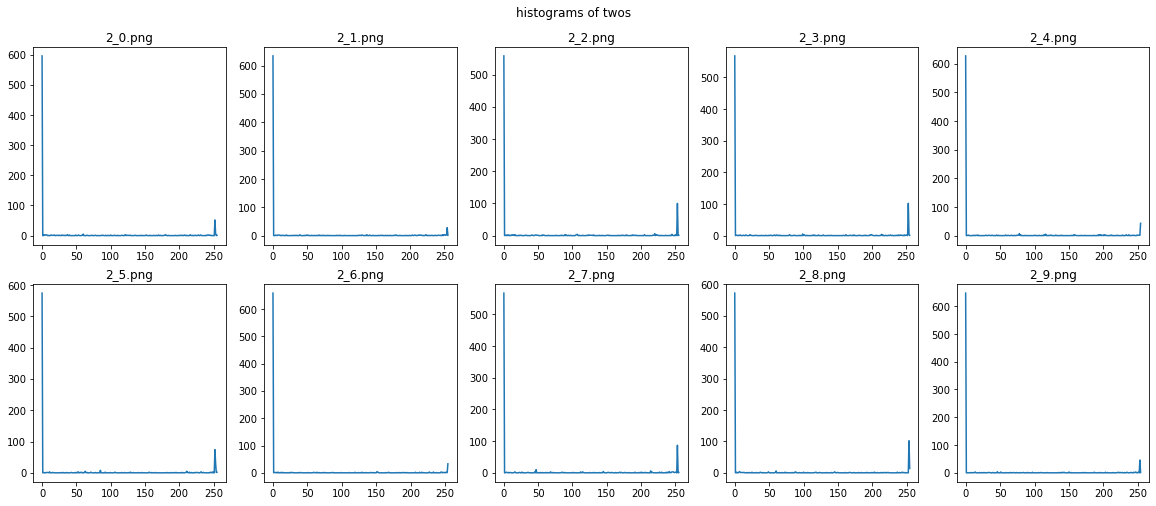

In [23]:
# visualizing the histograms of twos
fig, axes = plt.subplots(2, int(np.ceil(len(twos_im)/2)), figsize=(20, 8))
for i in range(0, len(twos_im), 1):
    ax = axes.ravel()[i]
    hist_vals, hist_centers = histogram(twos_im[i], nbins=256)
    ax.plot(hist_centers, hist_vals)
    ax.set_title(twos_names[i])
fig.suptitle('histograms of twos', y=0.95)
plt.show()

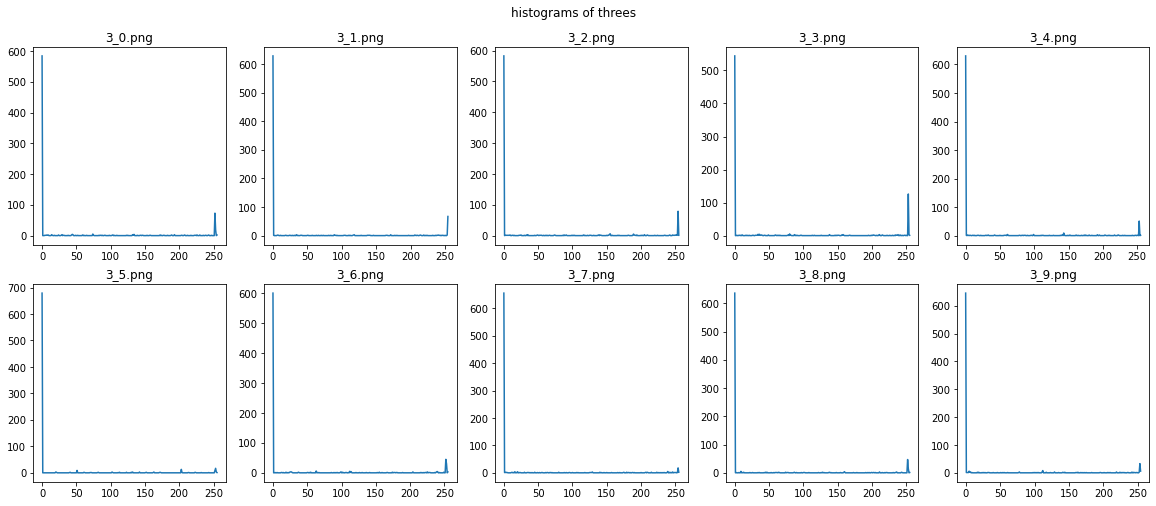

In [24]:
# visualizing the histograms of threes
fig, axes = plt.subplots(2, int(np.ceil(len(threes_im)/2)), figsize=(20, 8))
for i in range(0, len(threes_im), 1):
    ax = axes.ravel()[i]
    hist_vals, hist_centers = histogram(threes_im[i], nbins=256)
    ax.plot(hist_centers, hist_vals)
    ax.set_title(threes_names[i])
fig.suptitle('histograms of threes', y=0.95)
plt.show()

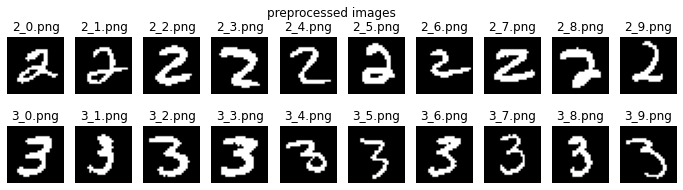

In [25]:
# preprocessing the images by thresholding them
threshold = 127
twos = twos_im.copy()
for i in range(0, len(twos), 1):
    twos[i] = preprocess(twos[i], threshold)
threes = threes_im.copy()
for i in range(0, len(threes), 1):
    threes[i] = preprocess(threes[i], threshold)
# Plot images
fig, axes = plt.subplots(2, len(twos), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
fig.suptitle("preprocessed images")
plt.show()

In [26]:
def calc_properties(img):
    """
    calculating different region based properties (for both compacity and additional methods)
    """
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    contour_largest = contours[0]
    area = cv2.contourArea(contour_largest)
    perimeter = cv2.arcLength(contour_largest, closed=True)
    compacity = (perimeter**2)/area
    x, y, w, h = cv2.boundingRect(contour_largest)
    aspect_ratio = float(w)/h
    extent = float(area)/(w*h)  # rectangularity
    hull_area = cv2.contourArea(cv2.convexHull(contour_largest))
    solidity = float(area)/hull_area
    equivalent_diameter = np.sqrt(4*area/np.pi)
    moments = cv2.moments(contour_largest)
    hu = cv2.HuMoments(moments).flatten()
    ellipse = cv2.fitEllipse(contour_largest)
    major_axis = max(ellipse[1])
    minor_axis = min(ellipse[1])
    eccentricity = np.sqrt(1-((minor_axis**2)/(major_axis**2)))
    elongation = major_axis/minor_axis
    return area, perimeter, compacity, aspect_ratio, extent, solidity, equivalent_diameter, hu, eccentricity, elongation

In [27]:
twos_areas = [None]*len(twos)
twos_perimeters = [None]*len(twos)
twos_compacities = [None]*len(twos)
twos_aspect_ratios = [None]*len(twos)
twos_extents = [None]*len(twos)
twos_solidities = [None]*len(twos)
twos_equivalent_diameters = [None]*len(twos)
twos_hu = [None]*len(twos)
twos_eccentricities = [None]*len(twos)
twos_elongations = [None]*len(twos)
threes_areas = [None]*len(threes)
threes_perimeters = [None]*len(threes)
threes_compacities = [None]*len(threes)
threes_aspect_ratios = [None]*len(threes)
threes_extents = [None]*len(threes)
threes_solidities = [None]*len(threes)
threes_equivalent_diameters = [None]*len(threes)
threes_hu = [None]*len(threes)
threes_eccentricities = [None]*len(threes)
threes_elongations = [None]*len(threes)

for i in range(len(twos)):
    twos_areas[i], twos_perimeters[i], twos_compacities[i], twos_aspect_ratios[i], twos_extents[i], twos_solidities[i], twos_equivalent_diameters[i], twos_hu[i], twos_eccentricities[i], twos_elongations[i] = calc_properties(twos[i])
for i in range(len(threes)):
    threes_areas[i], threes_perimeters[i], threes_compacities[i], threes_aspect_ratios[i], threes_extents[i], threes_solidities[i], threes_equivalent_diameters[i], threes_hu[i], threes_eccentricities[i], threes_elongations[i] = calc_properties(threes[i])

In [28]:
print(all(i >= 4*np.pi for i in twos_compacities))  # checking the validty of the compacity
print(all(i >= 4*np.pi for i in threes_compacities))    # checking the validty of the compacity

True
True


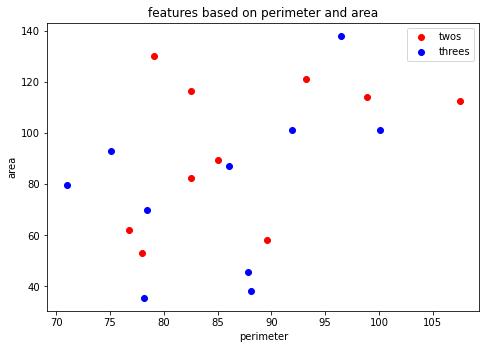

In [29]:
# Fill the arrays below with the perimeter and area as features for "2"s and "3"s images
twos_f1 = twos_perimeters.copy()
twos_f2 = twos_areas.copy()
threes_f1 = threes_perimeters.copy()
threes_f2 = threes_areas.copy()

# Plot features for all images
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(twos_f1, twos_f2, color='r', label='twos')
ax.scatter(threes_f1, threes_f2, color='b', label='threes')
ax.legend(loc='best')
ax.set_xlabel('perimeter')
ax.set_ylabel('area')
plt.title("features based on perimeter and area")
plt.show()

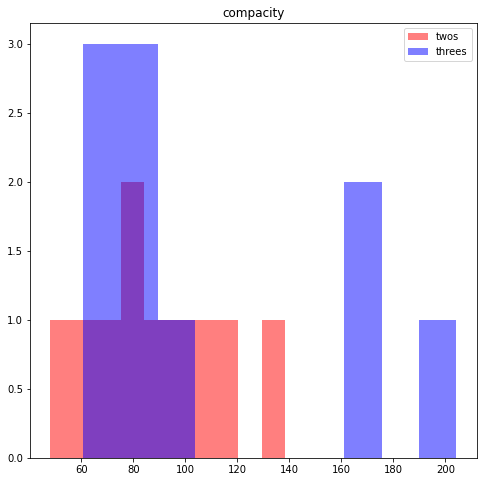

In [30]:
# Make the 1D plot of compacity
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.hist(twos_compacities, color='r', label='twos', alpha=0.5)
ax.hist(threes_compacities, color='b', label='threes', alpha=0.5)
ax.legend(loc='best')
ax.set_title("compacity")
plt.show()

####  Discussion

Clearly from figures, nor perimiter nor area cannot create separate clusters of the given images of twos and threes. Moreover, the overlap in the compacity properity is evident in the 1d plot (histogram visulaization) above. Therefore, we have tried to test other region based techniques and asses their performance in clustering twos and threes in the section below.

### 2.2. Additional method (4 pts)

#### region based features, including aspect ratio, extent (rectangularity), solidity, equivalent diameter, eccentricity, and elongation

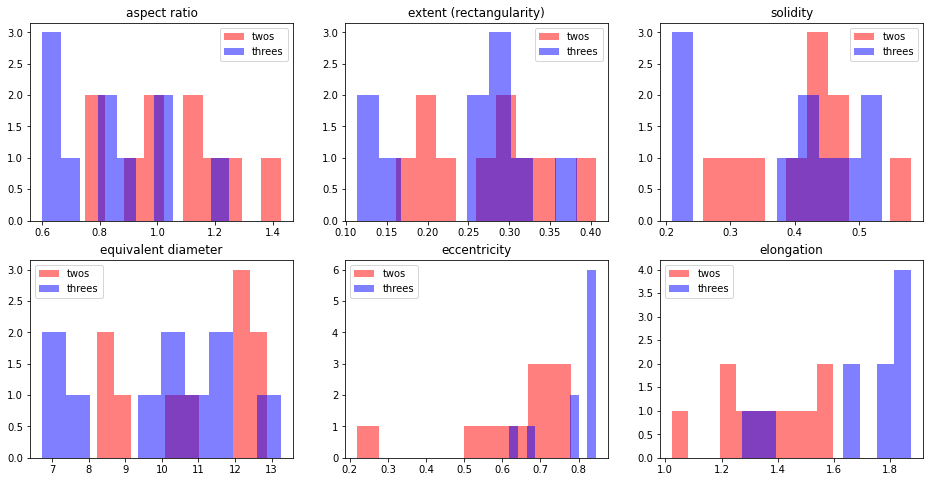

In [31]:
# Make the 1D plot of different properties
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes[0, 0].hist(twos_aspect_ratios, color='r', label='twos', alpha=0.5)
axes[0, 0].hist(threes_aspect_ratios, color='b', label='threes', alpha=0.5)
axes[0, 0].legend(loc='best')
axes[0, 0].set_title("aspect ratio")
axes[0, 1].hist(twos_extents, color='r', label='twos', alpha=0.5)
axes[0, 1].hist(threes_extents, color='b', label='threes', alpha=0.5)
axes[0, 1].legend(loc='best')
axes[0, 1].set_title("extent (rectangularity)")
axes[0, 2].hist(twos_solidities, color='r', label='twos', alpha=0.5)
axes[0, 2].hist(threes_solidities, color='b', label='threes', alpha=0.5)
axes[0, 2].legend(loc='best')
axes[0, 2].set_title("solidity")
axes[1, 0].hist(twos_equivalent_diameters, color='r', label='twos', alpha=0.5)
axes[1, 0].hist(threes_equivalent_diameters, color='b', label='threes', alpha=0.5)
axes[1, 0].legend(loc='best')
axes[1, 0].set_title("equivalent diameter")
axes[1, 1].hist(twos_eccentricities, color='r', label='twos', alpha=0.5)
axes[1, 1].hist(threes_eccentricities, color='b', label='threes', alpha=0.5)
axes[1, 1].legend(loc='best')
axes[1, 1].set_title("eccentricity")
axes[1, 2].hist(twos_elongations, color='r', label='twos', alpha=0.5)
axes[1, 2].hist(threes_elongations, color='b', label='threes', alpha=0.5)
axes[1, 2].legend(loc='best')
axes[1, 2].set_title("elongation")
plt.show()

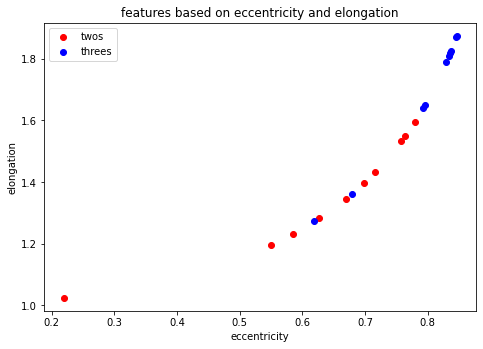

In [32]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(twos_eccentricities, twos_elongations, color='r', label='twos')
ax.scatter(threes_eccentricities, threes_elongations, color='b', label='threes')
ax.legend(loc='best')
ax.set_xlabel('eccentricity')
ax.set_ylabel('elongation')
plt.title("features based on eccentricity and elongation")
plt.show()

#### Hu moments

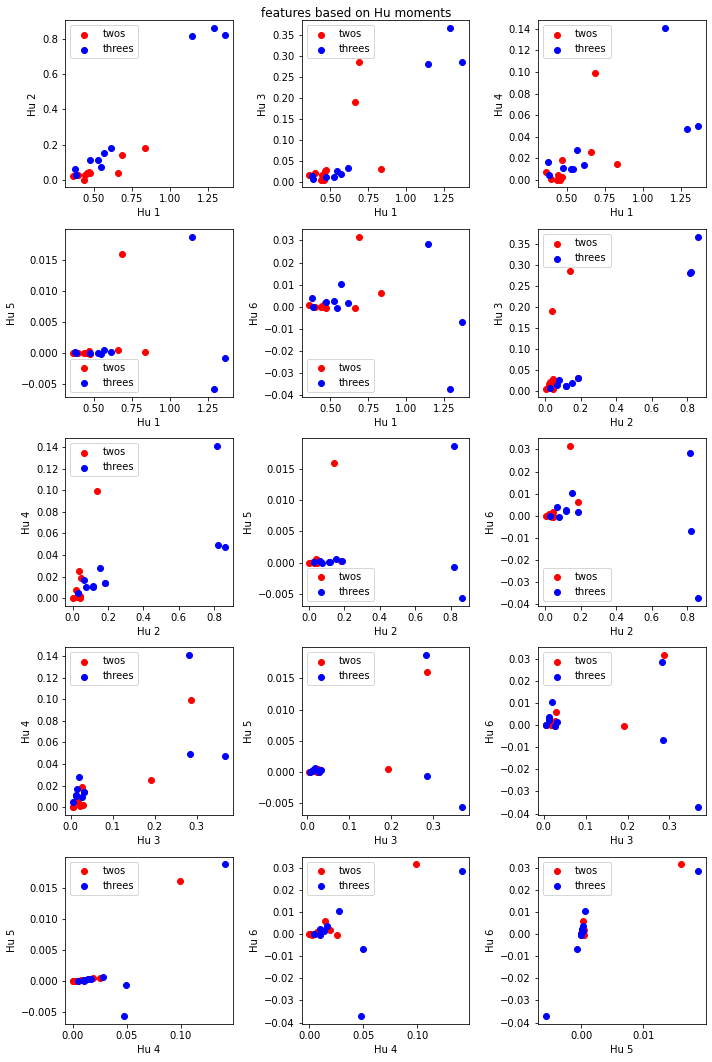

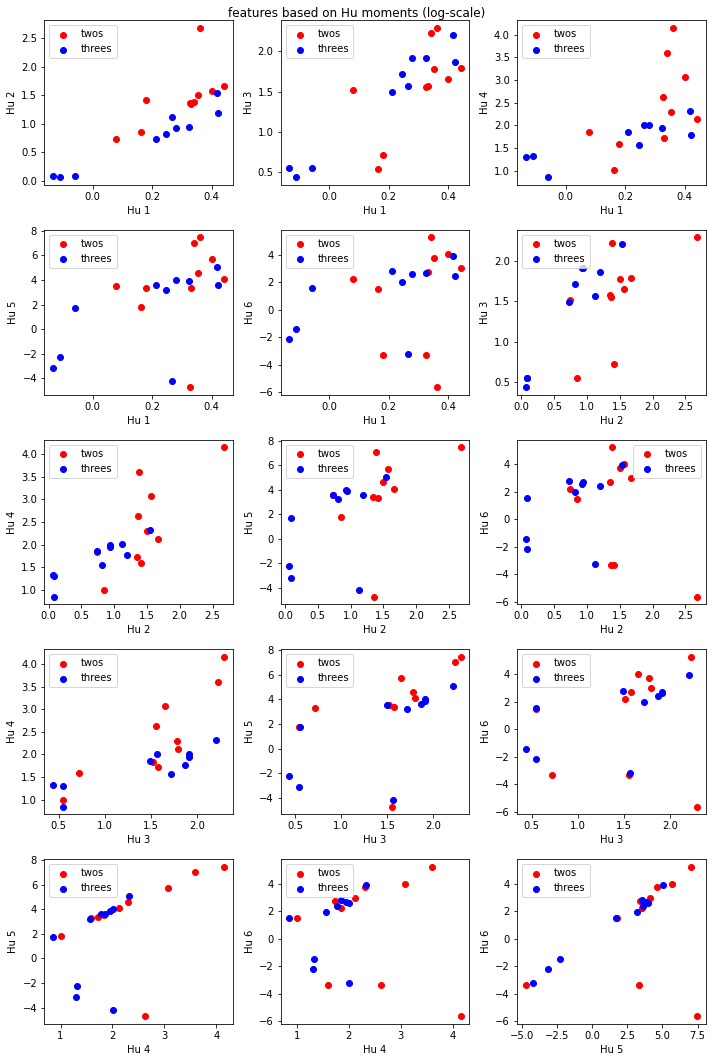

In [33]:
twos_hu = np.array(twos_hu)
twos_hu_log = -np.sign(twos_hu) * np.log10(np.abs(twos_hu))
threes_hu = np.array(threes_hu)
threes_hu_log = -np.sign(threes_hu) * np.log10(np.abs(threes_hu))
# plotting all combination of hu moments as 2d scatters
combinations = list(itertools.combinations(range(6), 2))
fig, axes = plt.subplots(5, 3, figsize=(10, 15))
for i, ax in enumerate(axes.flat):
    if i < len(combinations):
        x, y = combinations[i]
        ax.scatter(twos_hu[:, x], twos_hu[:, y], color='r', label='twos')
        ax.scatter(threes_hu[:, x], threes_hu[:, y], color='b', label='threes')
        ax.legend(loc='best')
        ax.set_xlabel(f'Hu {str(x+1)}')
        ax.set_ylabel(f'Hu {str(y+1)}')
    else:
        ax.set_axis_off()
plt.suptitle("features based on Hu moments")
plt.tight_layout()
plt.show()
# plotting all combination of hu moments (log-scale) as 2d scatters
fig, axes = plt.subplots(5, 3, figsize=(10, 15))
for i, ax in enumerate(axes.flat):
    if i < len(combinations):
        x, y = combinations[i]
        ax.scatter(twos_hu_log[:, x], twos_hu_log[:, y], color='r', label='twos')
        ax.scatter(threes_hu_log[:, x], threes_hu_log[:, y], color='b', label='threes')
        ax.legend(loc='best')
        ax.set_xlabel(f'Hu {str(x+1)}')
        ax.set_ylabel(f'Hu {str(y+1)}')
    else:
        ax.set_axis_off()
plt.suptitle("features based on Hu moments (log-scale)")
plt.tight_layout()
plt.show()

#### projections

In [34]:
def calc_projections(img):
    # projecting the object onto x-axis and y-axis
    x_proj = np.sum(img, axis=1)
    y_proj = np.sum(img, axis=0)

    # calculating the width and height of tje projections
    x_width = np.sum(x_proj > 0)
    y_height = np.sum(y_proj > 0)

    # finding local maximas and minimas
    x_grad = np.gradient(x_proj)
    y_grad = np.gradient(y_proj)

    x_maximas = np.where((np.hstack([x_grad, 0]) < 0) & (np.hstack([0, x_grad]) > 0))[0]
    x_minimas = np.where((np.hstack([x_grad, 0]) > 0) & (np.hstack([0, x_grad]) < 0))[0]
    y_maximas = np.where((np.hstack([y_grad, 0]) < 0) & (np.hstack([0, y_grad]) > 0))[0]
    y_minimas = np.where((np.hstack([y_grad, 0]) > 0) & (np.hstack([0, y_grad]) < 0))[0]

    # returning features
    features = [x_width, y_height, len(x_maximas), len(x_minimas), len(y_maximas), len(y_minimas)]
    return features

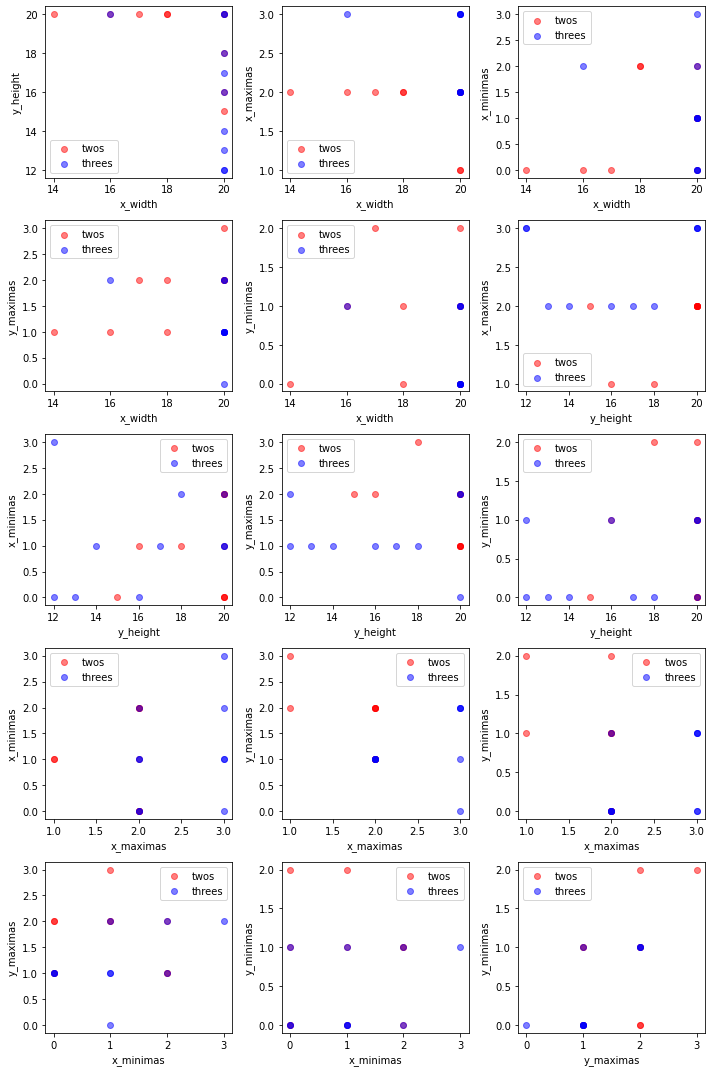

In [35]:
twos_projections = [None]*len(twos)
threes_projections = [None]*len(threes)
for i in range(len(twos)):
    twos_projections[i] = calc_projections(twos[i])
for i in range(len(threes)):
    threes_projections[i] = calc_projections(threes[i])
twos_projections = np.array(twos_projections)
threes_projections = np.array(threes_projections)
# plot all combination of projections as 2d scatters
combinations = list(itertools.combinations(range(6), 2))
labels = ['x_width', 'y_height', 'x_maximas', 'x_minimas', 'y_maximas', 'y_minimas']
fig, axes = plt.subplots(5, 3, figsize=(10, 15))
for i, ax in enumerate(axes.flat):
    if i < len(combinations):
        x, y = combinations[i]
        ax.scatter(twos_projections[:, x], twos_projections[:, y], color='r', label='twos', alpha=0.5)
        ax.scatter(threes_projections[:, x], threes_projections[:, y], color='b', label='threes', alpha=0.5)
        ax.set_xlabel(labels[x])
        ax.set_ylabel(labels[y])
        ax.legend(loc='best')
    else:
        ax.set_axis_off()
plt.tight_layout()
plt.show()


#### inertia axes

In [36]:
def get_inertia_axes(img):
    # computing the moments of the given preprocessed image
    moments = cv2.moments(img)
    
    # computing the normalized central moments of the binary image
    mu11 = moments['mu11'] / moments['m00']
    mu20 = moments['mu20'] / moments['m00']
    mu02 = moments['mu02'] / moments['m00']
    
    # computing the major and minor axes of inertia
    theta = 0.5 * np.arctan2(2 * mu11, mu20 - mu02)
    major_axis = np.sqrt(8 * (mu20 + mu02 + np.sqrt(4 * mu11**2 + (mu20 - mu02)**2)))
    minor_axis = np.sqrt(8 * (mu20 + mu02 - np.sqrt(4 * mu11**2 + (mu20 - mu02)**2)))
    
    return major_axis, minor_axis, theta

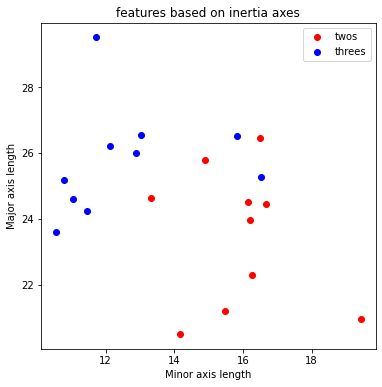

In [37]:
twos_major_axes, twos_minor_axes, twos_theta = zip(*[get_inertia_axes(im) for im in twos])
threes_major_axes, threes_minor_axes, threes_theta = zip(*[get_inertia_axes(im) for im in threes])
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(twos_minor_axes, twos_major_axes, color='r', label='twos')
ax.scatter(threes_minor_axes, threes_major_axes, color='b', label='threes')
ax.set_title("features based on inertia axes")
ax.set_xlabel('Minor axis length')
ax.set_ylabel('Major axis length')
ax.legend(loc='best')
plt.show()


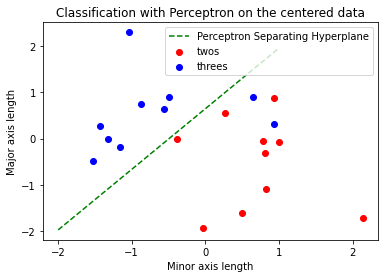

In [38]:
twos_minor_axes = np.array(twos_minor_axes)
threes_minor_axes = np.array(threes_minor_axes)
twos_major_axes = np.array(twos_major_axes)
threes_major_axes = np.array(threes_major_axes)
twos_features = np.hstack((twos_minor_axes[:, np.newaxis], twos_major_axes[:, np.newaxis]))
threes_features = np.hstack((threes_minor_axes[:, np.newaxis], threes_major_axes[:, np.newaxis]))
classify(twos_features, threes_features, 'twos', 'threes',
         'Minor axis length', 'Major axis length')  

#### inertia eigenvalues

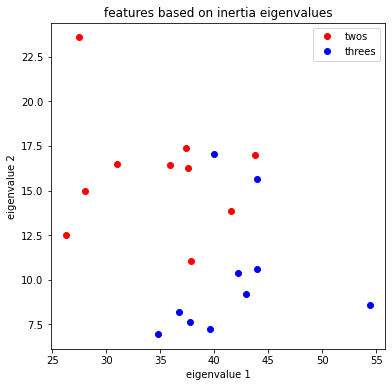

In [39]:
twos_inertia_eigvals = [inertia_tensor_eigvals(img) for img in twos]
threes_inertia_eigvals = [inertia_tensor_eigvals(img) for img in threes]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(np.array(twos_inertia_eigvals)[:, 0], np.array(twos_inertia_eigvals)[:, 1], 'ro', label='twos')
ax.plot(np.array(threes_inertia_eigvals)[:, 0], np.array(threes_inertia_eigvals)[:, 1], 'bo', label='threes')
ax.set_title("features based on inertia eigenvalues")
ax.set_xlabel("eigenvalue 1")
ax.set_ylabel("eigenvalue 2")
ax.legend(loc='best')
plt.show()

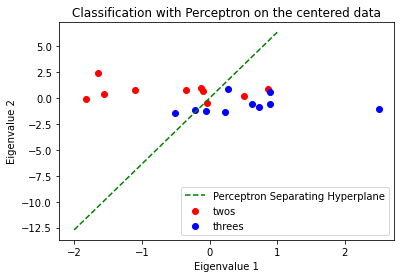

In [40]:
twos_features = np.array(twos_inertia_eigvals)
threes_features = np.array(threes_inertia_eigvals)
classify(twos_features, threes_features, 'twos', 'threes',
         'Eigenvalue 1', 'Eigenvalue 2')

#### Discussion

As it is plotted above, aspect ratio, extent (rectangularity), solidity, equivalent diameter, eccentricity, and elongation all show overlap between the clusters of twos and threes. The best combanation of those is attributed to the 2d representation of eccentricity and elongation in which there are two missclassfied threes.

Hu moments (normal and in log-scale) are a set of seven moments, among which, the first six are invariant to rotation, translation, and scaling. The 2d plots for each combination of those moments also failed to nicely separate twos and threes.

Similarly, the projection technique (calculating width, height, and number of local minimas and maximas along x and y axes) reveals a lot of overlap between twos and threes.

Some descriptors are also computed using the inertia axis length and inertia eigienvalues. The feature representation based on the inertia axis length can effectively differentiate between the classes of twos and threes. As depicted, the perceptron classifer can come up with a nice linear boundary between the clusters of twos and threes (only two of the threes are missclustered). The interia eigenvalues also bring about a similar result. In total, on can observe from the given images that twos are elongated in two directions, whereas threes are elongated in only one direction. Hence we can extract and differentate these characterestics by the inertia descriptor (axis length and eigenvalues).